# Principal Uncertainty Quantification with Spatial Correlation for Image Restoration Problems

**For an in-depth understanding of our method, we strongly recommend reading our paper.**

In this notebook, we illustrate the process of creating valid uncertainty regions using our codebase. To demonstrate this, we apply it to the task of colorization over the CelebA dataset. We utilize a samples dataset generated by a diffusion model that was initially trained for colorization on the FFHQ dataset.

In [1]:
from puq import DAPUQUncertaintyRegion
from puq import DiffusionSamplesDataset, GroundTruthsDataset, DiffusionSamplesDataLoader, GroundTruthsDataLoader

import torch
from argparse import Namespace
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as T

In [2]:
config = {

    'method': 'da_puq',
    'data': '/mnt/paper_celeba/parse2/colorization',
    'patch_res': None,

    'test_ratio': 0.5,
    'seed': 42,
    'gpu': 0,
    'batch': 100,

    'num_workers': 12,
    'no_cache': True,

    'alpha': 0.1,
    'beta': 0.1,
    'q': 0.95,
    'delta': 0.1,

    'num_reconstruction_lambdas': 100,
    'num_coverage_lambdas': 100,
    'num_pcs_lambdas': 20,
    'max_coverage_lambda': 10.0,

}

config = Namespace(**config)

To begin, let's load the model for the DA-PUQ uncertainty region.

In [3]:
region_model = DAPUQUncertaintyRegion(config)

If the data structure aligns with the description provided in the readme file, we can proceed to load the calibration data, which includes the sample dataset generated by a conditional stochastic generator (for example, a diffusion model) and its corresponding ground truths.

In [4]:
cal_samples_dataset = DiffusionSamplesDataset(
    opt=config,
    calibration=True,
    transform=T.ToTensor()
)

cal_ground_truths_dataset = GroundTruthsDataset(
    opt=config,
    samples_dataset=cal_samples_dataset,
    transform=T.ToTensor()
)

Visual representation of sample outputs from our diffusion model:

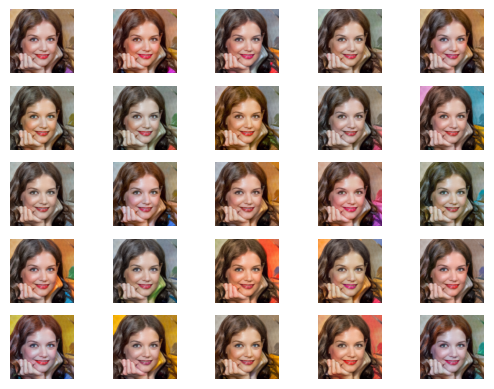

In [5]:
dl = DiffusionSamplesDataLoader(
    cal_samples_dataset,
    batch_size=config.batch,
    patch_res=config.patch_res,
    num_workers=config.num_workers
)
dl = iter(dl)
samples = dl.next()

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        index = j + 5 * i
        axs[i, j].imshow(samples[80, index].transpose(0,1).transpose(1,2))
        axs[i, j].axis('off')
plt.show()

Visual representation of the ground truth image:

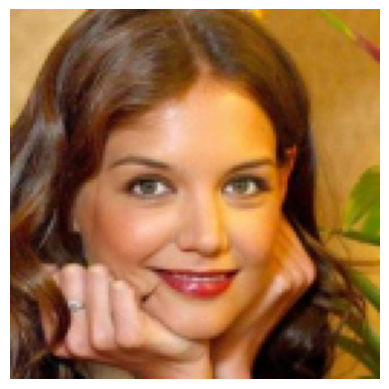

In [6]:
dl = GroundTruthsDataLoader(
    cal_ground_truths_dataset,
    batch_size=config.batch,
    patch_res=config.patch_res,
    num_workers=config.num_workers
)
dl = iter(dl)
images = dl.next()

plt.imshow(images[80].transpose(0,1).transpose(1,2))
plt.axis('off')
plt.show()

We proceed to apply the calibration procedure to obtain valid uncertainty regions that consider both coverage and reconstruction. Reconstruction validity entails that the latent space comprised of the diffusion samples' principal components can reconstruct the projected ground truth into a full-dimensional image with the error specified by the user (beta=0.1). Coverage validity ensures that the projected ground truth falls within the intervals of our latent space with high probablity (alpha=0.1).

In [7]:
region_model.calibration(cal_samples_dataset, cal_ground_truths_dataset)
f'coverage_lambda={region_model.coverage_lambda}, reconstruction_lambda={region_model.reconstruction_lambda}'

100%|██████████| 10/10 [01:38<00:00,  9.82s/it]


'coverage_lambda=1.6363636255264282, reconstruction_lambda=0.5858585834503174'

The resulting `coverage_lambda` determines the scaling factor for the intervals within our latent space. The resulting `reconstruction_lambda` sets an upper limit on the decay of singular values for each set of samples, allowing for a dynamic selection of the number of principal components. This approach assigns more principal components to instances with significant semantic uncertainty and fewer principal components to instances with lower uncertainty.

Now, let's assess the effectiveness of our uncertainty region model for the colorization task by applying it to the unseen test data.

In [8]:
test_samples_dataset = DiffusionSamplesDataset(
    opt=config,
    calibration=False,
    transform=T.ToTensor()
)

test_ground_truths_dataset = GroundTruthsDataset(
    opt=config,
    samples_dataset=test_samples_dataset,
    transform=T.ToTensor()
)

region_model.eval(test_samples_dataset, test_ground_truths_dataset)

100%|██████████| 10/10 [01:01<00:00,  6.18s/it]


{'coverage_risk': 0.049031721986830236,
 'reconstruction_risk': 0.06664899326860904,
 'interval_size': 0.16430229991674422,
 'dimension': 2.028999936580658,
 'max_dimension': 200.0,
 'uncertainty_volume': 3.0439438122864535e-11}

Let's provide descriptions for each metric:

- Coverage Risk: This metric quantifies the proportion of the projected ground truth that falls outside the uncertainty region, considering a threshold of `alpha=0.1`.
- Reconstruction Risk: This metric measures the reconstruction error of the ground truths recovered from the projected ground truths using the selected principal components, considering a threshold of `beta=0.1`.
- Interval Size: It represents the average length of the intervals within our latent space, which together form the uncertainty region.
- Dimension: This metric denotes the average number of principal components we offer to the user to meet the specified constraints. Dimension corresponds to the number of uncertainty axes provided to the user.
- Max Dimension: This metric indicates the number of samples utilized in composing the regions.
- Uncertainty Volume: This metric quantifies the average volume of the uncertainty regions. A smaller region implies a more confined set of solutions while still ensuring validity.

We will now proceed to visualize the uncertainty regions generated by our DA-PUQ approach when applied to the colorization task using the unseen data.

In [9]:
dl = DiffusionSamplesDataLoader(
    test_samples_dataset,
    batch_size=config.batch,
    patch_res=config.patch_res,
    num_workers=config.num_workers
)
dl = iter(dl)

image_shape = [3, 128, 128]
batch_samples = dl.next().flatten(2)
batch_mu, batch_pcs, batch_svs, batch_lower, batch_upper = region_model.inference(batch_samples)

Let's provide descriptions for each component that makes up the uncertainty regions:

- `batch_mu`: This represents the mean image of the approximate posterior distributions p(y|x).
- `batch_pcs`: These are the selected principal components.
- `batch_svs`: These are the corresponding singular values.
- `batch_lower`: This vector denotes the lower bound in the latent space of the principal components.
- `batch_upper`: This vector denotes the upper bound in the latent space of the principal components.

Visualization of the mean images and the uncertainty axes:

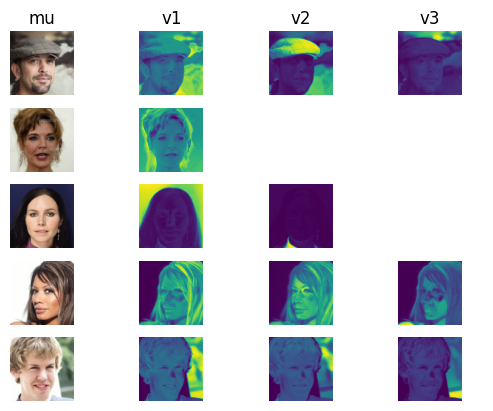

In [10]:
fig, axs = plt.subplots(5, 4)

for i in range(5):

    axs[i, 0].imshow(batch_mu[i].view(image_shape).transpose(0,1).transpose(1,2))
    axs[i, 0].axis('off')

    for axis_i in range(3):
        if batch_pcs[i].shape[1] > axis_i:
            axis_image = batch_pcs[i][:, axis_i].view(image_shape).pow(2).sum(dim=0, keepdim=True).sqrt()
            axs[i, axis_i+1].imshow(axis_image.transpose(0,1).transpose(1,2), cmap='viridis')
        axs[i, axis_i+1].axis('off')

cols = ['mu', 'v1', 'v2', 'v3']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

plt.show()

We will explore different potential solutions within our uncertainty regions by moving along random directions within the region. It's important to note that our method ensures a high probability of including the ground truth image in the set of solutions, while also guaranteeing a small reconstruction error.

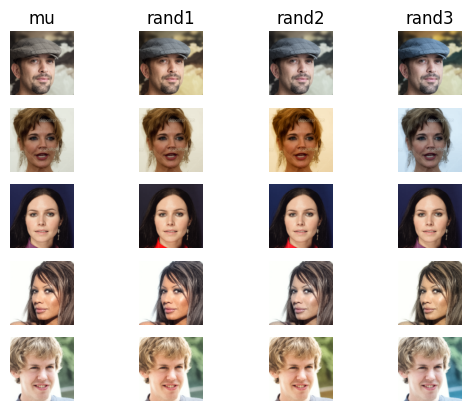

In [11]:
fig, axs = plt.subplots(5, 4)

for i in range(5):

    axs[i, 0].imshow(batch_mu[i].view(image_shape).transpose(0,1).transpose(1,2))
    axs[i, 0].axis('off')

    pcs_num = batch_svs[i].shape[0]
    random_values = (batch_lower[i] - batch_upper[i]) * torch.rand(3, pcs_num) + batch_upper[i]
    for j in range(3):
        random_sample = (batch_mu[i] + batch_pcs[i] @ random_values[j])
        random_sample.clamp_(0,1)
        axs[i, j+1].imshow(random_sample.view(image_shape).transpose(0,1).transpose(1,2))
        axs[i, j+1].axis('off')

cols = ['mu', 'rand1', 'rand2', 'rand3']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

plt.show()

Now, we will visualize the lower and upper corners of the uncertainty regions within the image domain.

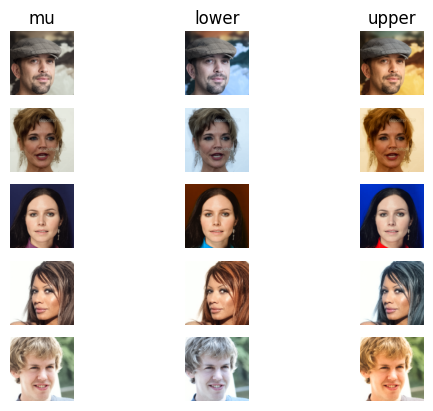

In [12]:
fig, axs = plt.subplots(5, 3)

for i in range(5):

    axs[i, 0].imshow(batch_mu[i].view(image_shape).transpose(0,1).transpose(1,2))
    axs[i, 0].axis('off')

    lower_image = (batch_mu[i] + batch_pcs[i] @ batch_lower[i]).clamp_(0, 1)
    axs[i, 1].imshow(lower_image.view(image_shape).transpose(0,1).transpose(1,2))
    axs[i, 1].axis('off')

    upper_image = (batch_mu[i] + batch_pcs[i] @ batch_upper[i]).clamp_(0, 1)
    axs[i, 2].imshow(upper_image.view(image_shape).transpose(0,1).transpose(1,2))
    axs[i, 2].axis('off')

cols = ['mu', 'lower', 'upper']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

plt.show()

We will visualize the central pathway between the lower and upper corners of the uncertainty regions in the image domain through a convex combination.

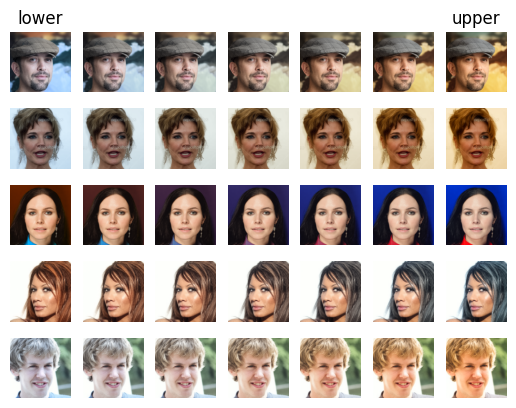

In [13]:

fig, axs = plt.subplots(5, 7)
param = torch.linspace(0, 1, 7).view(7, 1, 1, 1)

for i in range(5):
    lower_image = (batch_mu[i] + batch_pcs[i] @ batch_lower[i]).clamp_(0, 1)
    upper_image = (batch_mu[i] + batch_pcs[i] @ batch_upper[i]).clamp_(0, 1)
    traverse = upper_image.unsqueeze(0) * param + (1 - param) * lower_image.unsqueeze(0)
    for j in range(7):
        axs[i, j].imshow(traverse[j].view(image_shape).transpose(0,1).transpose(1,2))
        axs[i, j].axis('off')

cols = ['lower', '', '', '', '', '', 'upper']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

plt.show()